# Personalized Search

**NOTE**: This notebook depends upon the the Retrotech dataset. If you have any issues, please rerun the [Setting up the Retrotech Dataset](../ch4/1.ch4-setting-up-the-retrotech-dataset.ipynb) notebook.

In [7]:
import sys
sys.path.append('..')
from aips import *
import os
from IPython.display import display,HTML
from pyspark.sql import SparkSession

In [8]:
#Recommended for making ALS run faster, if you have enough memory / cores allocated to docker
from pyspark.conf import SparkConf
conf = SparkConf()
conf.set("spark.driver.memory", '8g')
#conf.set("spark.executor.cores", "6")
conf.set("spark.dynamicAllocation.enabled", "true")
#conf.set("spark.executor.memory", "11g")
#conf.set("spark.dynamicAllocation.executorMemoryOverhead", "11g")
#conf.set("spark.driver.memory", "11g")
spark = SparkSession.builder.appName("aips-ch9").config(conf=conf).getOrCreate()

In [9]:
### Load product data
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
products_collection = "products"    
product_update_opts={"zkhost": "aips-zk", "collection": products_collection}
spark.read.format("solr").options(**product_update_opts).load().createOrReplaceTempView("products")

# Collaborative Filtering with Implicit Preferences

In [10]:
def aggregate_signals(signals_collection, signals_aggregation_collection, signals_aggregation_query):

    create_collection(signals_aggregation_collection)

    print("Aggregating Signals to Create Signals Boosts...")
    signals_opts={"zkhost": "aips-zk", "collection": signals_collection}
    signals_boosting_opts={"zkhost": "aips-zk", "collection": signals_aggregation_collection, "gen_uniq_key": "true", "commit_within": "5000"}
    df = spark.read.format("solr").options(**signals_opts).load()
    df.createOrReplaceTempView("signals")


    spark.sql(signals_aggregation_query).write.format("solr").options(**signals_boosting_opts).mode("overwrite").save()
    print("Signals Aggregation Completed!")

## Listing 9.1

In [11]:
#Weighting multiple signal types by user
click_weight = 1
add_to_cart_weight = 0 #increase (i.e. to 10) to consider add to cart signals
purchase_weight = 0 #increase (i.e. to 25) to consider purchase signals

signals_collection="signals"
signals_aggregation_collection="user_product_implicit_preferences"

mixed_signal_types_aggregation = """
select user, product, (
      (1 * click_boost) 
    + (10 * add_to_cart_boost) 
    + (25 * purchase_boost) ) as rating
from (
  select user, product, 
    sum(click) as click_boost,
    sum(add_to_cart) as add_to_cart_boost,
    sum(purchase) as purchase_boost
  from (  
      select cap.user, cap.target as product, 
        if(cap.type = 'click', """f"{click_weight}"""", 0) as click, 
        if(cap.type = 'add-to-cart', """f"{add_to_cart_weight}"""", 0) as  add_to_cart, 
        if(cap.type = 'purchase', """f"{purchase_weight}"""", 0) as purchase
      from signals cap 
      where (cap.type != 'query')
    ) raw_signals
  group by user, product
) as per_type_boosts
"""

aggregate_signals(signals_collection, signals_aggregation_collection, mixed_signal_types_aggregation)

Wiping 'user_product_implicit_preferences' collection
[('action', 'CREATE'), ('name', 'user_product_implicit_preferences'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_product_implicit_preferences' collection
Status: Success
Aggregating Signals to Create Signals Boosts...
Signals Aggregation Completed!


In [12]:
user_prefs_options={"zkhost": "aips-zk", "collection": signals_aggregation_collection}
df = spark.read.format("solr").options(**user_prefs_options).load()
df.createOrReplaceTempView("user_product_implicit_preferences")

### TODO: verify the above table is fully written before proceeding. Need to ensure downstream issues don't occur (i.e. userIndexer.fit / productIndexer.fit method training on empty data.)

## Listing 9.2

In [13]:
##50K = all products
#This will take long time. Recommend setting to 1,000 if trying to just run through code
#without considering all products

top_product_count_for_recs = 50000 #all products. 

user_item_ratings = spark.sql(f"""
  select user, product, rating from user_product_implicit_preferences
  where product in (
    select product from (
      select product, count(user) user_count from user_product_implicit_preferences
      group by product
      order by user_count desc
      limit {top_product_count_for_recs}
    ) top_products
  )   
  order by rating desc""")

## Listing 9.3 

In [14]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import IndexToString

userIndexer = StringIndexer(inputCol="user", outputCol="userIndex").fit(user_item_ratings)
productIndexer = StringIndexer(inputCol="product", outputCol="productIndex").fit(user_item_ratings)

def stringsToIndexes(user_item_ratings,user_indexer,product_indexer):
    #Fits a model to the input dataset with optional parameters.
    return product_indexer.transform(user_indexer.transform(user_item_ratings))
    
def indexesToStrings(user_item_ratings,user_indexer,product_indexer):
    userIndexToString = IndexToString(inputCol="userIndex", outputCol="user",
                                    labels=user_indexer.labels)
    
    productIndexToString = IndexToString(inputCol="productIndex", outputCol="product",
                                    labels=product_indexer.labels)

    return userIndexToString.transform(productIndexToString.transform(user_item_ratings))

In [15]:
from pyspark.sql.functions import col
indexedUserPrefs = stringsToIndexes(user_item_ratings,userIndexer,productIndexer)
indexedUserPrefs.orderBy(col("userIndex").asc(),col("rating").desc()).show(10)

+-------+------------+------+---------+------------+
|   user|     product|rating|userIndex|productIndex|
+-------+------------+------+---------+------------+
|u159789|085391163121|     1|      0.0|      9196.0|
|u159789|886541105851|     1|      0.0|      1394.0|
|u159789|025193102324|     1|      0.0|      9650.0|
|u159789|886112115302|     1|      0.0|       548.0|
|u159789|008888345435|     1|      0.0|      5073.0|
|u159789|014633196870|     1|      0.0|      4525.0|
|u159789|720616236029|     1|      0.0|      2781.0|
|u159789|024543718710|     1|      0.0|       263.0|
|u159789|813985010007|     1|      0.0|      5819.0|
|u159789|801213001996|     1|      0.0|     28736.0|
+-------+------------+------+---------+------------+
only showing top 10 rows



## Listing 9.4

In [16]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

als = ALS(maxIter=3, rank=10, regParam=0.15, implicitPrefs=True, userCol="userIndex", itemCol="productIndex", ratingCol="rating", coldStartStrategy="drop", seed=0)
#-3939200230093063679

(training, test) = indexedUserPrefs.randomSplit([0.8, 0.2], 0)

print("Beginning model training")
model = als.fit(indexedUserPrefs)

print("Beginning predictions")
predictions = model.transform(test)

print("Beginning evaluation")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Beginning model training
Beginning predictions
Beginning evaluation
Root-mean-square error = 0.9589328844781423


## Listing 9.5

In [51]:
# Generate top 3 product recommendations for each user
indexedUserRecs = model.recommendForAllUsers(10)
indexedUserRecs.show(5)
#print(predictions.orderBy(col("userIndex").asc(),col("prediction").desc()))

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|       26|[{17, 0.037616048...|
|       27|[{17, 0.001811180...|
|       28|[{30, 0.06910295}...|
|       31|[{13, 0.008291349...|
|       34|[{14, 0.005998417...|
+---------+--------------------+
only showing top 5 rows



## Listing 9.6

In [18]:
from pyspark.sql.functions import explode, col

exploded = (indexedUserRecs.select("userIndex", explode("recommendations").alias("productIndex_rating"))).select("userIndex", col("productIndex_rating.*"))
userItemRecs = indexesToStrings(exploded,userIndexer,productIndexer).select("user", "product", col("rating").alias("boost"))

# Listing 9.7

In [19]:
import datetime 
print ("Start Time: " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

#Write recommendations to Solr
def write_boosts_signals(recommendations_collection, userItemRecs):

    create_collection(recommendations_collection)

    print("Writing recommendations to Solr...")
    signals_opts={"zkhost": "aips-zk", "collection": recommendations_collection}
    opts={"zkhost": "aips-zk", "collection": recommendations_collection, 
          "gen_uniq_key": "true", "commit_within": "5000"}
    userItemRecs.createOrReplaceTempView("temp_user_item_recs") #faster to use spark.sql than write df directly due to execution plan
    spark.sql("select * from temp_user_item_recs"
             ).write.format("solr").options(**opts).mode("overwrite").save()
    #userItemRecs.write.format("solr").options(**opts).mode("overwrite").save()
    print("Recommendations saved to table: " + recommendations_collection)
    
write_boosts_signals("user_item_recommendations", userItemRecs)

print ("End Time: " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start Time: 2023-10-26 21:13:55
Wiping 'user_item_recommendations' collection
[('action', 'CREATE'), ('name', 'user_item_recommendations'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_item_recommendations' collection
Status: Success
Writing recommendations to Solr...
Recommendations saved to table: user_item_recommendations
End Time: 2023-10-26 21:20:37


# Search with Recommendations Boosts
Whereas signals boosting boosts the most popular documents for a particular query (ch8), you can also boost the most personalized items for a particular user. In order to serve up the pre-generated collaborative recommendations we just generated, we can just need to run a search and boost the recommended items for each user.

## Listing 9.8

In [20]:
def search(collection="products", query="*:*", user="", 
           filters=[], sort="", fields=["*"], params={}):
    return requests.post(
             f"{SOLR_URL}/{collection}/select", json={
               "query":query, "filter": filters, "sort": sort, 
               "fields": fields, "params": params}
           ).json()["response"]


user = "u478462" #example user
signals_collection = "signals"

previous_searches = search(collection=signals_collection, 
                           filters=["user:" + user, "type:query"], 
                           sort="signal_time asc")["docs"]

product_interactions = search(
                                collection=signals_collection, 
                                filters=["user:" + user, "-type:query"], 
                                sort="signal_time asc")["docs"]

interacted_products = ""
for interaction in product_interactions:
    if len(interacted_products) > 0: interacted_products += " "
    interacted_products += interaction["target"]

product_search = search(
                    filters=["upc:(" + interacted_products + ")"]
                 )["docs"]
product_info = {}
for product in product_search:
    product_info[product["upc"]] = product["name"]\
        .replace("&#xAE;","®").replace("&#x2122;", "™") #replace encoded version to make more readable


print("User: " + str(user))
    
print("\nPrevious Searches: ")
for doc in previous_searches:
    print("--" + doc["target"])
    
print("\nPrevious Product Interactions: ")
for interaction in product_interactions:
    print("--type: " + interaction["type"] + ", name: " 
                     + product_info[interaction["target"]]) 

User: u478462

Previous Searches: 
--apple
--macbook

Previous Product Interactions: 
--type: click, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: add-to-cart, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: purchase, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: click, name: Apple® - MacBook® Air - Intel® Core™ i5 Processor - 11.6" Display - 4GB Memory - 128GB Flash Storage


## Listing 9.9

In [21]:
user = "u478462"
user_item_recs_collection = "user_item_recommendations"

def get_query_time_boosts(user, boosts_collection):
    user_filter = ["user:" + user] if user else []

    signals_boosts = search(
            boosts_collection, filters=user_filter, sort="boost desc", 
            fields = ["product", "boost"], params={"rows": 10}
        )["docs"]

    product_boosts = ""
    for entry in signals_boosts:
        if len(product_boosts) > 0:  product_boosts += " "
        product_boosts += '"' + str(entry['product']) \
                              + '"^' + str(float(entry['boost'])*100)

    return product_boosts

def run_main_query(query, signals_boosts, rows=5):     
    if not signals_boosts: signals_boosts = "*:*"
    if not query: query="*:*"
        
    main_query = search(
        query=query, fields=["upc", "name", "manufacturer", "score", "shortDescription"],
        sort="score desc, upc asc", params={
          "qf": "name manufacturer longDescription", 
          "defType": "edismax", "rows": rows,
          "boost": "sum(1,query({! df=upc v=$signals_boosting}))",
          "signals_boosting": signals_boosts
        })    
    
    return main_query

recommendations_boosts = get_query_time_boosts(user, "user_item_recommendations")
print("Boost Query:\n" + recommendations_boosts)

#recommendations
search_results = run_main_query(query=None, signals_boosts=recommendations_boosts, rows=6)["docs"]
print("\nRecommendations: ")
display(HTML(render_search_results("", search_results)))

Boost Query:
"885909457588"^75.393623 "097360810042"^18.904798 "821793013776"^15.852094 "610839379408"^10.217768000000001 "635753493559"^9.087185 "885909395095"^8.304988 "885909457595"^7.9175640000000005 "885909431618"^7.375394 "885909459858"^6.592548 "885909436002"^6.1031554

Recommendations: 


## Listing 9.10

In [22]:
#non-personalized query
query="tablet"
search_results = run_main_query(query=query, signals_boosts=None, rows=4)["docs"]
print(f"Non-personalized Query (q={query}): ")
display(HTML(render_search_results(query, search_results)))

Non-personalized Query (q=tablet): 


In [23]:
#personalized query
search_results = run_main_query(query=query, signals_boosts=recommendations_boosts, rows=7)["docs"]
print(f"Personalized Query (q={query}, user={user}): ")
display(HTML(render_search_results(query, search_results)))

Personalized Query (q=tablet, user=u478462): 


# Vector-based Personalization

In [24]:
spark.sql("""select count(upc), count(distinct upc),count(name), count(distinct name), count(distinct shortDescription) from products g""").show(2)

+----------+-------------------+-----------+--------------------+--------------------------------+
|count(upc)|count(DISTINCT upc)|count(name)|count(DISTINCT name)|count(DISTINCT shortDescription)|
+----------+-------------------+-----------+--------------------+--------------------------------+
|     48194|              46155|      48194|               46124|                           19024|
+----------+-------------------+-----------+--------------------+--------------------------------+



## Listing 9.11

In [25]:
### Create the product data set for embeddings 
product_dataframe=spark.sql("""
  select distinct name, string(upc), shortDescription, 
  concat(name," ",shortDescription ) as name_desc from products""")
product_dataframe.createOrReplaceTempView("products_samples")
#product_texts=product_dataframe.select("name_desc").rdd.flatMap(lambda x: x).collect()
product_names=product_dataframe.select("name").rdd.flatMap(lambda x: x).collect()
product_ids=product_dataframe.select("upc").rdd.flatMap(lambda x: x).collect()


In [26]:
len(product_ids),len(product_names)

(48164, 48164)

In [ ]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

## Listing 9.12

In [28]:
### Get the embedding 
import pickle, os
from sentence_transformers import SentenceTransformer
## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer('all-mpnet-base-v2')
embFileName='../data/product_data_embeddings_all-mpnet-base-v2_names_all_embed.pickle'
dataFileName= '../data/product_data_embeddings_all-mpnet-base-v2_names_all_names.pickle'
iDsFileName= '../data/product_data_embeddings_all-mpnet-base-v2_names_all_ids.pickle'

###
def getEmbeddings(texts,ids,ignore_cache=False):
    load_from_cache=True
    
    if ignore_cache or not (os.path.isfile(embFileName) and os.path.isfile(dataFileName) and os.path.isfile(iDsFileName)):
        load_from_cache=False  
        
    if not load_from_cache:
        embeddings = transformer.encode(texts, convert_to_tensor=False)
        with open(embFileName,'wb') as fd:
            pickle.dump(embeddings,fd)
        with open(dataFileName,'wb') as fd:
            pickle.dump(texts,fd)
        with open(iDsFileName,'wb') as fd:
            pickle.dump(ids,fd)
    else:
        with open(embFileName,'rb') as fd:
            embeddings = pickle.load(fd)
        with open(dataFileName,'rb') as fd:
            texts = pickle.load(fd)
        with open(iDsFileName,'rb') as fd:
            ids = pickle.load(fd)
    return embeddings,texts,ids

In [29]:
#product_embeddings=getEmbeddings(p_texts,load_from_cache=True)
#product_embeddings=getEmbeddings(product_names,load_from_cache=True)

product_embeddings,product_names,product_ids=getEmbeddings(product_names,product_ids)


In [30]:
### Product Ids-embedding, Product ID-names dictionaries 
product_ids_emb = dict(zip(product_ids, product_embeddings))
product_ids_names= dict(zip(product_ids, product_names))
#len(product_texts), len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())
len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())

(48164, 48164, 48164, 46155)

In [31]:
######## Cluster the product info
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time


## Listing 9.13

In [32]:
## Get the clusters 
def get_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    algo=algorithm(*args, **kwds).fit(data)
    end_time = time.time()
    return algo

In [33]:

### K-means clustering
algo=get_clusters(product_embeddings, cluster.KMeans, (), {'n_clusters':100, 'n_init':10, 'random_state':0})
labels = algo.predict(product_embeddings)
centers=algo.cluster_centers_



In [34]:
def assign_clusters(labels,product_names):
    clusters={}
    clusters = defaultdict(lambda:[],clusters)
    for l in range(0,len(labels)):
        clusters[labels[l]].append(product_names[l])
    return clusters

In [35]:
clusters=assign_clusters(labels,product_names)

In [36]:
#from sklearn.manifold import TSNE
#X = np.array(centers, dtype=np.float32)
#X.shape
#tsne = TSNE(random_state=0, n_iter=1000)
#tsne_results = tsne.fit_transform(X)
#df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
#df_tsne['Cluster'] = clusters.keys()
#fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
#sns.set_style('darkgrid', {"grid.color": "0.6", "grid.linestyle": ":"})
#sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title('Scatter plot of products using KMeans Clustering');
#plt.xlabel('TSNE1');
#plt.ylabel('TSNE2');
#plt.axis('equal')

## Listing 9.14

81

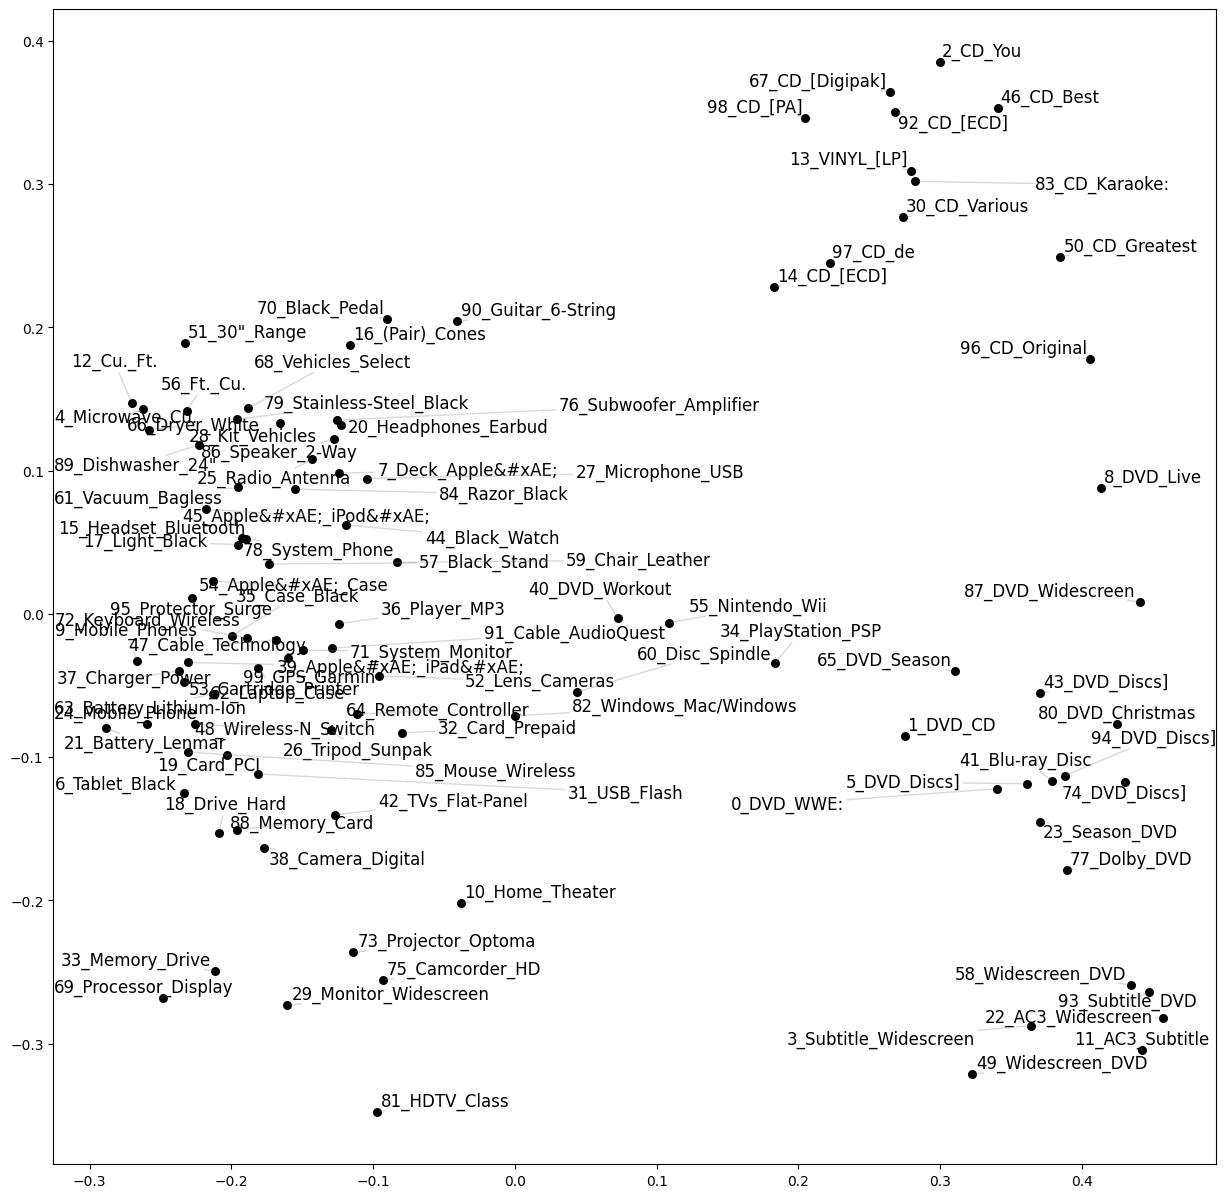

In [37]:
import collections, itertools
from sklearn.decomposition import PCA

stopwords = ['in', 'for', 'with', 'of', 'the', "to", "and"]

def top_words(clusters, top_n):
    # Loop through the clusters and split each string on space
    tokenized = [cluster.split() for cluster in clusters]
    
    # Flatten the list of lists
    flattened = list(itertools.chain.from_iterable(tokenized))
    
    filtered = [word for word in flattened if len(word) > 1 and word.lower() not in stopwords]
    
    # Return the most common words
    return [ word for word, count in collections.Counter(filtered).most_common(top_n) ]

#Importing required modules

from adjustText import adjust_text
import numpy as np
import matplotlib.pyplot as plt
 
data = centers
pca = PCA(100, svd_solver="full")
 
#Transform the data for 2-D visualization

plt.figure(figsize=(15,15))

plot_data = pca.fit_transform(centers)
#plot_data = centers
#plt.scatter(plot_data[:,0] , plot_data[:,1] , s = 30, color = 'k')

text_labels = []
for i, cluster_name in enumerate(plot_data):
    plt.scatter(plot_data[i,0] , plot_data[i,1] , s = 30, color = 'k') 
    text_labels.append(plt.text(plot_data[i,0], 
                                plot_data[i,1],str(i) + "_" +"_".join(top_words(clusters[i],2)), fontsize=12))
adjust_text(text_labels, arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))

In [38]:
clusters[1]  #useful for spot checking clusters to ensure items inside are homogenous

['Music Pro Guides: Logic Pro 7 - Advanced Level - DVD',
 'Elite - DVD',
 'Fagbug - DVD',
 'MI-5, Vol. 1 [3 Discs] - DVD',
 'Masked and Anonymous - (Ws Sub Ac3 Dol) - DVD',
 'Tool: Schism - DVD',
 'Help! - DVD',
 'Inside Genesis: A Critical Review - 1975-1980 - Dts - DVD',
 'Mandingo - DVD',
 'Evangelion 2.0: You Can (Not) Advance - DVD',
 '35 Rhums - DVD',
 'Renovation Nation: Recycle Reuse & Reclaim - DVD',
 'The Ultimate Physics Tutor - Fullscreen - DVD',
 'Sony - 60-Minute MiniDV Digital Video Cassettes (6-Pack)',
 'Soca Gold 2009 [CD & DVD] - Various CD+DVD - CD',
 'Gidget: Complete Collection [2 Discs] - (Full) - DVD',
 'Funky Phantom [4 Discs] - Fullscreen - DVD',
 'Initial D: Stage 4 - Part Two (2 Disc) - DVD',
 'The NB Ridaz: Official DVD - DVD',
 'Chico Buarque: MPB Especial - DVD',
 'Tell Me Why: Computers/The Internet - DVD',
 'Rounders/Swingers [2 Discs] - DVD',
 'I Tried - DVD',
 'Maximum Overdrive/Raw Deal - DVD',
 'Dual Survival (2 Disc) - DVD',
 "Breakin' vs. Krumpin' 

In [39]:
#sample top keywords in each cluster (same as figure above, but more data)
cluster_labels = {}

for cluster_key in range(0,99):
    print(f"{{ cluster: {cluster_key}, top_words: {top_words(clusters[cluster_key], 20)}}}")

{ cluster: 0, top_words: ['DVD', 'WWE:', 'Fullscreen', 'Ultimate', 'Blu-ray', 'Disc', 'AC3', 'UFC', 'Dolby', 'Greatest', 'vs.', '2010', 'Best', 'Discs]', 'Fighting', 'NFL:', 'Vol.', 'Season', 'Series', 'TNA']}
{ cluster: 1, top_words: ['DVD', 'CD', 'DVD]', '[CD', '(Ws', 'Discs]', 'Sub', 'Dol)', 'Disc)', 'Windows', 'Video', '[2', 'Vol.', 'Ws', 'Fullscreen', '(2', '[PA]', 'Box', 'Pro', 'Ac3']}
{ cluster: 2, top_words: ['CD', 'You', 'Me', 'Love', 'VINYL', 'All', 'My', 'Is', 'Your', 'Up', 'We', 'It', 'Life', 'on', '[PA]', 'This', '[ECD]', 'Heart', 'No', 'Like']}
{ cluster: 3, top_words: ['Subtitle', 'Widescreen', 'DVD', 'Dolby', 'AC3', 'Dubbed', 'Fullscreen', 'Dts', 'Blu-ray', 'Disc', 'UMD', 'Saw', 'Dead', 'III', 'One', 'Game', 'State', 'Black', 'Dirty', 'Blood']}
{ cluster: 4, top_words: ['Microwave', 'Cu.', 'Ft.', 'Stainless-Steel', 'Oven', 'Over-the-Range', 'Black', 'Built-In', 'Wall', 'GE', 'Electric', 'White', 'Convection', 'Mid-Size', 'Toaster', 'Single', 'Whirlpool', '30"', 'Frigida

In [40]:
import pandas as pd

### Create Pandas dataframes for product_clusters
product_ids_labels= dict(zip(product_ids, labels))
pddf_product_ids_labels=pd.DataFrame.from_dict(product_ids_labels,orient='index',columns=['label'])
pddf_product_ids_labels['pid']=pddf_product_ids_labels.index

## Listing 9.16

In [41]:
import sentence_transformers
import heapq

## get the top n clusters based on similairty with centers 
def get_top_labels_centers(query,centers ,N=2):
    q_emb = transformer.encode([query], convert_to_tensor=False)
    similarities = sentence_transformers.util.cos_sim(q_emb, centers)
    sim=similarities.tolist()[0]
    res = [sim.index(i) for i in heapq.nlargest(N, sim)]
    return res

### Get the cluster for the query based on prediction of the label
def get_query_cluster(query):
    q_emb = transformer.encode([query], convert_to_tensor=False)
    q_label=algo.predict(q_emb)
    return q_label

In [42]:
def get_cluster_description(clusterNum):
    return "_".join(top_words(clusters[clusterNum],5))

query="microwave"
#option 1: Find nearest cluster (KMeans)
kmeans_predict=get_query_cluster(query)[0]
print(f"KMeans Predicted Cluster:\n    {kmeans_predict} (" 
      + get_cluster_description(kmeans_predict) + ")")

#option 2: Find most similar cluster (Cosine similarity)
closest_cosine_similarity=get_top_labels_centers(query,centers,N=1)[0]
print(f"\nCosine Predicted Cluster:\n    {closest_cosine_similarity} (" 
      + get_cluster_description(closest_cosine_similarity) + ")")

#option 3: N-nearest clusters (Cosine similarity)
knn_cosine_similarity=get_top_labels_centers(query,centers,N=5)
print(f"\nKNN Cosine Predicted Clusters: {knn_cosine_similarity}")
for clusterNum in knn_cosine_similarity: print(f"    {clusterNum} (" 
      + get_cluster_description(clusterNum) +")")

KMeans Predicted Cluster:
    4 (Microwave_Cu._Ft._Stainless-Steel_Oven)

Cosine Predicted Cluster:
    4 (Microwave_Cu._Ft._Stainless-Steel_Oven)

KNN Cosine Predicted Clusters: [4, 79, 51, 56, 89]
    4 (Microwave_Cu._Ft._Stainless-Steel_Oven)
    79 (Stainless-Steel_Black_KitchenAid_Cuisinart_Maker)
    51 (30"_Range_Stainless-Steel_Freestanding_Self-Cleaning)
    56 (Ft._Cu._Refrigerator_Water_Thru-the-Door)
    89 (Dishwasher_24"_Built-In_Tall_Tub)


In [43]:
sdf_id_labels=spark.createDataFrame(pddf_product_ids_labels).createOrReplaceTempView('products_clusters')


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [44]:
# Load signal data to create user-product vectors 
signals_collection="signals"
signals_opts={"zkhost": "aips-zk", "collection": signals_collection}
df_signals = spark.read.format("solr").options(**signals_opts).load()
df_signals.createOrReplaceTempView("signals")


In [45]:
#Create User-product data set for personalization
spark.sql("""
select  distinct user, target as product_id , name  as product_name
from signals s join products_samples p on s.target=p.upc
""").createOrReplaceTempView("user_product")

df_user_p=spark.sql("""select user,product_id, product_name,label from user_product a join 
products_clusters b on a.product_id = b.pid """)

user_product_cluster_collection = "user_product_cluster"
create_collection(user_product_cluster_collection)
user_product_cluster_opts={"zkhost": "aips-zk", "collection": user_product_cluster_collection, "gen_uniq_key": "true", "commit_within": "5000"}
df_user_p.write.format("solr").options(**user_product_cluster_opts).mode("overwrite").save()

#rows=df_user_p.collect()




Wiping 'user_product_cluster' collection
[('action', 'CREATE'), ('name', 'user_product_cluster'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_product_cluster' collection
Status: Success


In [46]:
## get the top n clusters based on similarity with centers 
def get_top_clusters_for_embedding(embedding, N=2):
    similarities = sentence_transformers.util.cos_sim(embedding,centers)
    sim=similarities.tolist()[0]
    res = [sim.index(i) for i in heapq.nlargest(N, sim)]
    return res


## Listing 9.16

In [47]:
# importiong the modules
import pandas as pd
import numpy as np
np.set_printoptions(4)
  

#Take user's product interests and return dataframe containing embedding and guardrail cluster
def get_user_embeddings(products=[]):
    values = []
    for product in products:
        values.append([product_ids_emb[product], 
                       get_top_clusters_for_embedding(product_ids_emb[product],1)[0]])
    column_names = ["embedding", "cluster"]

    return pd.DataFrame(data = np.array(values), 
                  index = products, 
                  columns = column_names)

def get_user_personalization_vector(query=None, user_items=[], query_weight=1, user_items_weights=[]):
    #by default, weight is split 1:1 (50% each) between the query embedding and the user_items_weight.
    #you can manually add weights for each user_item to influence how much each element counts.

    query_embedding = transformer.encode(query, convert_to_tensor=False) if query else None
    
    if len(user_items) > 0 and len(user_items_weights) == 0:
        user_items_weights = np.full(shape=len(user_items), fill_value=1/len(user_items))
            
    embeddings = [] 
    embedding_weights = []
    for weight in user_items_weights:
        embedding_weights.append(weight)
    for embedding in user_items:
        embeddings.append(embedding)
    if query_embedding.any():
        embedding_weights.append(query_weight)
        embeddings.append(query_embedding)
                
    return np.average(embeddings,
                      weights=np.array(embedding_weights),axis=0).astype("double") if len(embeddings) > 0 else None

## Lsting 9.17

In [48]:
product_interests = [ #"883049181479",  #samsung stainless steel refrigerator, touchscreen
                      "7610465823828",  #hello kitty water bottle
                      "36725569478"]   #samsung stainless steel electric range
                      #"36725560475" ]  #samsung stainless steel double oven electric range

user_embeddings = get_user_embeddings(product_interests)
print(f"\nProducts Interactions for Personalization:\n {user_embeddings}")

query = "microwave"

unfiltered_personalization_vector = get_user_personalization_vector(
                            query=query,
                            user_items=user_embeddings['embedding'].to_numpy())
print("\nPersonalization Vector (No Cluster Guardrails):\n" + str(unfiltered_personalization_vector[0:5]).replace("]", "... ]"))


query_clusters=get_top_labels_centers(query,centers,N=5)
print("\nQuery Clusters ('microwave'):", query_clusters)

filtered_embeddings = user_embeddings[user_embeddings.cluster.isin(query_clusters)] #filter down to only items in the query clusters
print("\nProducts Filtered to Query Clusters:\n" + str(filtered_embeddings))

filtered_personalization_vector = get_user_personalization_vector(
                            query=query,
                            user_items=filtered_embeddings['embedding'].to_numpy())

print("\nFiltered Personalization Vector (With Cluster Guardrails):\n" + str(filtered_personalization_vector[0:5]).replace("]", "... ]"))


Products Interactions for Personalization:
                                                        embedding cluster
7610465823828  [0.06417942, 0.041785527, -0.0017139543, -0.02...      44
36725569478    [0.0055417735, -0.024302173, -0.024139365, -0....      51

Personalization Vector (No Cluster Guardrails):
[ 0.0164 -0.0062 -0.02   -0.0317 -0.0161... ]

Query Clusters ('microwave'): [4, 79, 51, 56, 89]

Products Filtered to Query Clusters:
                                                     embedding cluster
36725569478  [0.0055417735, -0.024302173, -0.024139365, -0....      51

Filtered Personalization Vector (With Cluster Guardrails):
[ 0.0018 -0.0227 -0.0256 -0.0369 -0.0254... ]


/tmp/ipykernel_838/453913026.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pd.DataFrame(data = np.array(values),


## Listing 9.18

In [49]:
# 4- Get all items for the search query using solr index
## Get the top items from the query cluster for the user
### User search query using solr 
import sys
sys.path.append('..')
from aips import *
#query="Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate"

query="microwave"

search_results = search(query=query, 
                        fields=["upc", "name", "manufacturer", "score"], 
                        sort="score desc, upc asc",
                        params={
                          "qf": "name manufacturer",
                          "defType": "edismax",
                          "rows": 100 })

print("Search Results w/ No Personalization:")
display(HTML(render_search_results(query, search_results["docs"][0:4])))


Search Results w/ No Personalization:


In [50]:
from operator import itemgetter


def rerank_with_personalization(search_results, personalization_vector):
    search_result_docs = search_results["docs"]

    result_embeddings=np.array([ product_ids_emb[search_result_docs[x]['upc']] for x in range(
        len(search_result_docs))]).astype(float)

    similarities = sentence_transformers.util.cos_sim(
        personalization_vector, result_embeddings).tolist()[0]

    reranked = [similarities.index(i) for i in heapq.nlargest(len(similarities), similarities)]
    reranked, values = zip(*sorted(enumerate(similarities), key=itemgetter(1),reverse=True))

    return [ search_result_docs[i] for i in reranked ]


#Show results without guardrails    
print("Personalized search results (no category guardrails):")
reranked_seach_results_no_guardrails =  rerank_with_personalization(search_results, unfiltered_personalization_vector) 
display(HTML(render_search_results(query, reranked_seach_results_no_guardrails[0:4])))

#Show results with guardrails
print("Personalized search results (with category guardrails):")
reranked_seach_results_with_guardrails =  rerank_with_personalization(search_results, filtered_personalization_vector) 
display(HTML(render_search_results(query, reranked_seach_results_with_guardrails[0:4])))


Personalized search results (no category guardrails):


Personalized search results (with category guardrails):


# Old ALS Code

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql.functions import col, explode

signals_collection = "signals"

# Load signals from Solr
signals_read_opts = {"zkhost": "aips-zk", "collection": signals_collection}
sql_filter = """select user, target, type
from signals
where user is not null and type='click'
"""
signals_df = spark.read.format("solr").options(**signals_read_opts).load()
signals_df.createOrReplaceTempView("signals")
signals_df = spark.sql(sql_filter)

# Encode 'user' and 'target' fields into integer IDs
indexer_user = StringIndexer(inputCol="user", outputCol="userId")
indexer_target = StringIndexer(inputCol="target", outputCol="itemId")

In [ ]:
index_model_user = indexer_user.fit(signals_df)
index_model_target = indexer_target.fit(signals_df)
signals_df = index_model_user.transform(signals_df)
signals_df = index_model_target.transform(signals_df)

# Prepare data for ALS model
data = signals_df.select(col("userId").cast("int"), 
                         col("itemId").cast("int"), 
                         col("type").cast("int"))

# Split the data into training and test sets
(training, test) = data.randomSplit([0.8, 0.2])



In [ ]:
# Initialize ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="itemId", ratingCol="type", coldStartStrategy="drop")

In [ ]:
# Train ALS model
model = als.fit(training)

In [ ]:
# Train ALS model
model = als.fit(training)

# Generate top 10 product recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Mapping back the 'userId' and 'itemId' to original 'user' and 'target' values
user_to_string_indexer = IndexToString(inputCol="userId", outputCol="user", labels=index_model_user.labels)
item_to_string_indexer = IndexToString(inputCol="itemId", outputCol="target", labels=index_model_target.labels)

userRecs = user_to_string_indexer.transform(userRecs)

# To convert the recommendations from array format to multiple rows,
# we explode the recommendations array
userRecs = userRecs.withColumn("recommendations", explode(userRecs.recommendations))

userRecs = item_to_string_indexer.transform(userRecs)

# Display the recommendations
userRecs.select("user", "recommendations.target", "recommendations.rating").show()
